# SECTION 1: SANITATION DATA

This section describes thee process of loading, processing and transformation of the available raw data into the shape and form suitable for clustering algorithms.

### SECTION 1.1: UPLOAD OF DATA TO GOOGLE COLAB

The data collected consists of 244 rows (points), each of which has 7 columns (features). The 7 features are:

1. Timestamp
2. GPS coordinates
3. Type of infrastructure component/features of interest
4. Rate the sanitary state of the identified feature
5. What is the main source of drinking water in the area?	
6. Are water treatment methods observed in the area?
7. If yes, what water treatment method is used? If no, why?

The first step in the analysis of the data was to upload a file called **sanitation_data.csv** from a local computer to Google Colab using Colab's library as show below (commented out because data had been uploaded to Google Colab at the time of writing this report):



In [138]:
########## LEAVE THIS COMMENTED BECAUSE THE FILE HAS BEEN UPLOADED ##########
#from google.colab import files
#sanitation_data = files.upload()
#elevations_json_data = files.upload()

### SECTION 1.2: PANDAS DATAFRAME

The data from **sanitation_data.csv** was read and converted into Pandas Data Frame using the Pandas library as shown below:

In [139]:
import pandas as pd
sanitation_data = pd.read_csv("sanitation_data.csv")

### SECTION 1.3: REMOVAL OF TIMESTAMP COLUMN

The first column of the **sanitation_data** dataframe obtained in SECTION 1.2 contained **Timestamp** column which were removed as follows:

In [140]:
sanitation_data = sanitation_data.drop(["Timestamp"],axis=1)

### SECTION 1.4: DECOUPLING OF GPS COORDINATES

The **GPS Coordinates** column of the sanitation data was in the form of a string **"latitude, longitude"**. This form of representation was decoupled into separate numerical **latitude** and **longitude** columns as follows:

In [141]:
temp= sanitation_data[['GPS coordinates']]
lat_long_sanitation=pd.DataFrame()
lat_long_sanitation[['latitude','longitude']] = temp['GPS coordinates'].str.split(',',expand=True).astype(float)

### SECTION 1.5: DREMOVAL OF GPS COORDINATES COLUMN
The **GPS Coordinates** column was then removed from the dataframe as follows:

In [142]:
sanitation_data = sanitation_data.drop(['GPS coordinates'], axis=1)
#print(sanitation_data.head())

At this point, there are two Pandas dataframes.

The **sanitation_data** with the following columns:

1. Type of infrastructure component/features of interest
2. Rate the sanitary state of the identified feature
3. What is the main source of drinking water in the area?
4. Are water treatment methods observed in the area?
5. If yes, what water treatment method is used? If no, why?

The **lat_long_sanitation** with the following columns:

1. latitude
2. longitude

### SECTION 1.6: INSERTION OF ELEVATION COLUMN INTO lat_long_sanitation

The **GPS Coordinates** column described in SECTION 1.4 resulted into only two separate numerical columns for latitudes and longitudes. A third column, called **elevation**, which contained heights at the corresponding longitudes and latitudes was added with the help of [Google's Point Elevation API](https://developers.google.com/maps/documentation/elevation/overview). The API simply returns a json file with the heights for each latitude-longitude pair. This file was renamed to **elevations_data.json**. The following code shows how this API can be used.

In [143]:
temp=lat_long_sanitation.to_csv(header=None, index=False).split('\n')
lat_long_API = '|'.join([str(elem) for elem in temp]) 
lat_long_API = lat_long_API[0:-1]
#print(lat_long_API)
#https://maps.googleapis.com/maps/api/elevation/json?locations=lat_long_API&key=YOUR_API_KEY

The file **elevations_data.json** was uploaded to Google Colab in SECTION 1.1 along with **sanitation_data.csv**

All the elevations from **elevations_data.json** were loaded into **elevations** list as follows:

In [144]:
import json

with open('elevations_data.json') as f:
  elevations_data = json.load(f)

elevations = []

for i in elevations_data["results"]:
  elevations.append(i.get("elevation"))

The elevations of the **elevations** list were joined with the latitudes and longitudes of the **lat_long_sanitation** dataframe to form **lat_long_ele_sanitation** dataframe as follows:

In [145]:
lat_long_ele_sanitation = lat_long_sanitation
lat_long_ele_sanitation["elevation"] = elevations

### SECTION 1.7: TRANSFORMATION OF LATITUDES, LONGITUDES, AND ELEVATIONS INTO X, Y,  Z COORDINATES

By this point, there are three Pandas dataframes. 

The **sanitation_data** with the following columns:
1. Type of infrastructure component/features of interest
2. Rate the sanitary state of the identified feature
3. What is the main source of drinking water in the area?
4. Are water treatment methods observed in the area?
5. If yes, what water treatment method is used? If no, why?


The **lat_long_sanitation** with the following columns:
1. latitude
2. longitude

and the **lat_long_elev_sanitation** with the following columns:
1. latitude
2. longitude
3. elevation


Since the latitudes, longitudes, and elevations are angular measurements, they can't be linearly scalled to produce meaningul results in clustering algorithms such as **K-means**, which is one of the clustering algorithms to be covered in SECTION 2.

### SECTION 1.7.1: GEODETIC TO ECEF CONVERSION

One of the common ways of converting latitudes ($\phi$), longitudes ($\lambda$), and elevation ($h$) from their polar form to their linear/cartesian form (X,Y,Z) is called Geodetic to ECEF (acronym for earth-centered, earth-fixed) conversion.

In this conversion, we have:

$X = (N(\phi)+h)cos(\phi)cos(\lambda)$

$Y = (N(\phi)+h)cos(\phi)sin(\lambda)$

$Z = \left(\frac{b²}{a²}N(\phi)+h \right)sin(\phi)$

Where:

$N(\phi)=\frac{a}{\sqrt{1-e^{2}sin^2\phi}}$ and $e^{2}=1-\frac{b^2}{a^2}$

and

$a=6378137.0 m$

$b=6356752.314245 m m$

The following code implements the above set of equations to transform the polar coordinates in **lat_long_ele_sanitation** dataframe to their linear/cartesian equivalent in the **X_Y_Z** dataframe.

In [146]:
import math


a=6378137.0
b=6356752.314245
e_squared=1-(b**2)/(a**2)

# Latitude (deg), Longitude (deg), Elevation (meters)
def geodetic_to_ecef(latitude,longitude,elevation):
    
    lamb = math.radians(latitude)
    phi = math.radians(longitude)
    h=elevation



    Nphi=a/math.sqrt(1-e_squared*(math.sin(lamb))**2)

    sin_lambda = math.sin(lamb)
    cos_lambda = math.cos(lamb)
    sin_phi = math.sin(phi)
    cos_phi = math.cos(phi)

    X = (Nphi+h) * cos_lambda * cos_phi
    Y = (Nphi+h) * cos_lambda * sin_phi
    Z = (((1 - e_squared) * Nphi)+h)* sin_lambda

    return X,Y,Z

X_Y_Z=lat_long_ele_sanitation.apply(lambda row:geodetic_to_ecef(row["latitude"],row["longitude"],row["elevation"]), axis=1)

# Convert the series to Pandas DataFrame
X_Y_Z = X_Y_Z.to_frame()
X_Y_Z = pd.DataFrame(X_Y_Z[0].to_list(), columns=['X','Y','Z'])


#print(X_Y_Z)
#print(sanitation_data)

### SECTION 1.7.2: COMBINING TRANSFORMED COORDINATES WITH REST OF DATA

The following code shows the joining of **X_Y_Z** dataframe to **sanitation_data** dataframe to form the **xyz_sanitation_data** dataframe that has the basic form for clustering in SECTION 2.

In [147]:
x_y_z_sanitation_data = pd.DataFrame()
x_y_z_sanitation_data = pd.concat([X_Y_Z,sanitation_data], axis=1)
#print(x_y_z_sanitation_data)

# SECTION 2: DATA CLUSTERING
This section aims to leverage on some of the popular clustering algorithms available today to determine if there is any relationship between the different variables of the sanitation data provided. This section will also take a look at possible spacial connection between different data points using the non-categorical variables of the data (X,Y,Z + Sanitation rate).

### SECTION 2.1: GOWER'S SIMILARITY MATRIX 

Since the transformed data, **xyz_sanitation_data** (SECTION 1.7.2), contains both numerical and categorical information, it may not be apparent which of the variables are similar, or disimilar. **Gower's matrix** computes the similarities/disimilarities of mixed variables (numerical and categorical) in data by calculating all the pair-wise distances between every data point within the data.
Gower's similarity matrix can therefore be used to find similarities, and perhaps uncover some patterns, within **xyz_sanitation_data** since while X, Y, Z and the "Rate the sanitary state" are numerical, the rest of the variables are categorical.

A 0 distance means the pair are 100% similar (variable measures distance to itself), and a 1 means a given pair of data is 100% disimilar (the opposite).



### SECTION 2.1.1: APPLICATION OF GOWER'S MATRIX ON SANITATION DATA

The code below installs and imports gower and other libraries.

In [148]:
####################################################################
print("********************************************")
!pip install gower
print("********************************************")
import gower
import numpy as np
####################################################################

********************************************
********************************************


A single line of code using the gower library on the **xyz_sanitation_data** dataframe is all that is needed to produce a 244x244 square matrix (since there are 244 data points as mentioned in SECTION 1.1. All possible pairwise distances is $244^2$ ). The leading diagonal of the reulting square matrix are all 0s. Below is the code:

In [149]:
####################################################################
similarity_matrix=gower.gower_matrix(x_y_z_sanitation_data)
print(similarity_matrix)
####################################################################

[[0.         0.142777   0.4622949  ... 0.41503987 0.44185585 0.32222214]
 [0.142777   0.         0.47530717 ... 0.43821704 0.34030977 0.21023442]
 [0.4622949  0.47530717 0.         ... 0.6273348  0.6124841  0.23492724]
 ...
 [0.41503987 0.43821704 0.6273348  ... 0.         0.276816   0.612262  ]
 [0.44185585 0.34030977 0.6124841  ... 0.276816   0.         0.4724113 ]
 [0.32222214 0.21023442 0.23492724 ... 0.612262   0.4724113  0.        ]]


The sum of the scores in the matrix along the rows (axis=0) or the columns (axis=1) will be the total score each data point gets from other data points. Below is the code that calculates this score. The total number of sums will be a list containing 244 scores in the following order: 

datapoint0 = 114.146385

datapoint1 = 114.11417

datapoint2 = 123.006035

datapoint3 = 120.0327

|

|

|

datapoint242 = 103.37557

datapoint243 = 116.147285

datapoint0 to datapoint243 are essentially the rows of the **xyz_sanitation_data** dataframe from top to bottom. 

In [150]:
####################################################################
sum_similar=np.sum(similarity_matrix,axis=0) 
print("Total Scores = ",len(sum_similar))
print(sum_similar)
####################################################################

Total Scores =  244
[114.146385 114.11417  123.006035 120.0327   114.66806  120.93319
 107.12157   96.621605  96.621605 118.65828  111.69758  114.197975
 114.15205  105.01369   99.38868   99.38868  117.64148  104.121574
 117.1647    92.743835  92.743835  98.66204  117.63417  102.48917
  92.743835  92.743835 101.706604 122.528015  92.743835 100.50137
 108.05404  108.05404  108.05404  102.08105   96.08105   96.06713
  96.06713  122.39903  101.845314 102.59344  102.59344  108.21844
 102.59344  112.22514  103.03285  110.15785  127.61974  123.44162
  97.92541   99.11424  109.116295 103.03285  103.6798   104.75897
 122.572    116.01605  103.03285  118.41439  123.7894   118.41439
 123.95701  121.77068  119.99786  118.91851  121.50158  108.533356
 110.42644  110.37476  120.78455  110.30668  109.327736 117.02591
 116.65833  115.47504  110.99023  124.349785  99.24627  108.58451
 119.28486  129.23738  121.328156 106.28259  117.01306   94.085884
 123.13649  112.09154   94.026634  94.02667   94.026

If we plot a Histogram with 15 bins for example, we can see that the Gower score increases from left to right. We can assume that those data points closest to the score of 90 should be the most similar to each other.

Conversely, we can also assume that those data points closest to the score of 130, should be the least similar.



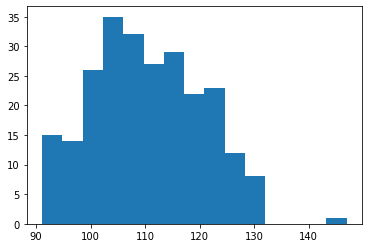

In [151]:
####################################################################
import matplotlib.pyplot as plt
plt.hist(sum_similar, bins=15)
plt.show()
####################################################################

Suppose we get the indices of the 15 data points with lowest Gower scores close to 90, what would the variables of these data points look like?
The code is provided below. 

In [152]:
K=15
features= ["Type of infrastructure component/features of interest",
           "Rate the sanitary state of the identified feature",
           "What is the main source of drinking water in the area?",
           "Are water treatment methods observed in the area?",
           "If yes, what water treatment method is used? If no, why?"]

####################################################################
# Out of 244 data points, find the indices of the first K points 
# with SMALLEST Gower value (i.e most similar)
####################################################################
FIRST_K_SMALLEST_IDX=np.sort(np.argpartition(sum_similar,K)[:K])

# Print the responses
print("***************************************")
for i in FIRST_K_SMALLEST_IDX:
  for j in features:
    print(x_y_z_sanitation_data.loc[i,j])
  print("***************************************")
####################################################################

***************************************
Run off water/sewer line
4
Borehole
YES
Chlorination
***************************************
Run off water/sewer line
4
Borehole
YES
Chlorination
***************************************
Run off water/sewer line
4
Borehole
YES
Chlorination
***************************************
Run off water/sewer line
4
Borehole
YES
Chlorination
***************************************
Run off water/sewer line
4
Borehole
YES
Chlorination
***************************************
Run off water/sewer line
5
Borehole
YES
Chlorination
***************************************
Run off water/sewer line
5
Borehole
YES
Chlorination
***************************************
Run off water/sewer line
5
Borehole
YES
Chlorination
***************************************
Run off water/sewer line
5
Borehole
YES
Chlorination
***************************************
Public/shared toilets
4
Borehole
YES
Chlorination
***************************************
Run off water/sewer line
5
Boreho

The rabove esults were then analsed using the [Word Frequency counter](http://www.writewords.org.uk/word_count.asp) with the following output:

In [153]:
"""
15 yes
15 water
15 chlorination
13 borehole
11 sewer
11 run
11 off
11 line
8: 4
6: 5
1: 3
2 tap
2 point
2 community
1 toilets
1 tank
1 storage
1 shared
1 public
"""

'\n15 yes\n15 water\n15 chlorination\n13 borehole\n11 sewer\n11 run\n11 off\n11 line\n8: 4\n6: 5\n1: 3\n2 tap\n2 point\n2 community\n1 toilets\n1 tank\n1 storage\n1 shared\n1 public\n'

The above results suggest that 

A) there is high similarity between the words "yes", "water", and "chlorination".

B) There is also high similarity between the words, "sewer", "run", "off", "line"

C) "borehole" is somewhere between A and B.

### **This means that, using Gower's similarity matrix, the most confident we can be using the available data is that the main source of drinking in areas with Run off water/sewer lines is chlorinated water from boreholes and the sanitation rate is 4/10. It also means that this group of data described above can form its own cluster**

Suppose we repeat the experiment with 15  other data points closest to the Gower score of 130, what would the variables of these data points look like?
The code is provided below. 



In [154]:
####################################################################
# Out of 244 data points, find the indices of the first K points 
# with LARGEST Gower value (i.e most similar)
####################################################################
FIRST_K_LARGEST_IDX=np.sort(np.argpartition(-sum_similar,K)[:K])


# Print the responses
print("***************************************")
for i in FIRST_K_LARGEST_IDX:
  for j in features:
    print(x_y_z_sanitation_data.loc[i,j])
  print("***************************************")
####################################################################

***************************************
Manhole
1
Storage tank
NO
They have no idea
***************************************
Manhole
1
Running tap
NO
No storage tanks
***************************************
Run off water/sewer line
2
Tap water
YES
Boiling water
***************************************
Solid waste site
1
Storage tank
NO
Not sure if treated
***************************************
Open water bodies
1
Non
NO
There are none
***************************************
Solid waste site
1
Non 
NO
None
***************************************
Solid waste site
1
Non 
NO
None
***************************************
Solid waste site
1
Tap water 
NO
None
***************************************
Manhole
1
Storage tank
NO
Not sure says its from the city council
***************************************
Solid waste site
2
Tap from olerai 
NO
None
***************************************
Open water bodies
3
Tap water 
NO
None 
***************************************
Open water bodies
3
Bottle wat

Once again, the results were analysed using the Word Frequency Counter with the following output:

In [155]:
"""
17 no (over 100%. Meaning 2 NOs were given to wrong questions)
12 water
11:1
8 waste
8 solid
8 site
8 none
5 tap
4 tank
4 storage
3 sure
3 open
3 not
3 non
3 manhole
3 bodies
2: 2
3: 2
2 vendor
2 the
2 from
1 yes
1 unaware
1 treated
1 they
1 there
1 tanks
1 sewer
1 says
1 running
1 run
1 point
1 olerai
1 off
1 observed
1 line
1 its
1 is
1 if
1 idea
1 have
1 council
1 community
1 city
1 bottle
1 boiling
1 are
"""

'\n17 no (over 100%. Meaning 2 NOs were given to wrong questions)\n12 water\n11:1\n8 waste\n8 solid\n8 site\n8 none\n5 tap\n4 tank\n4 storage\n3 sure\n3 open\n3 not\n3 non\n3 manhole\n3 bodies\n2: 2\n3: 2\n2 vendor\n2 the\n2 from\n1 yes\n1 unaware\n1 treated\n1 they\n1 there\n1 tanks\n1 sewer\n1 says\n1 running\n1 run\n1 point\n1 olerai\n1 off\n1 observed\n1 line\n1 its\n1 is\n1 if\n1 idea\n1 have\n1 council\n1 community\n1 city\n1 bottle\n1 boiling\n1 are\n'

=========================================================================================================================================================================================================================================================================================================================================================

# <font color='black'>SECTION 3: RESULTS </font>

# <font color='red'>SECTION 4: DISCUSSION </font>

# <font color='indigo'>SECTION 5: CONCLUSION </font>





